In [1]:
from catboost import CatBoostClassifier, Pool
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from xgboost import XGBClassifier, DMatrix, plot_importance, plot_tree
from lightgbm import LGBMClassifier, Dataset
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [42]:
catboost_params = {
    "iterations": 2000,
    "depth": 1,
    "learning_rate": 0.07,
    "loss_function": "Logloss",
    "verbose": False,
    "eval_metric": 'AUC',
    "od_type": 'Iter',
    "od_wait": 300,
}

lr_params = {
    "C": 1.5,
    "fit_intercept": True,
    "max_iter": 300,
    "penalty": "l1",
    "random_state": 123,
    "solver": "liblinear"
}

catboost_columns = [
    'term',
    'acc_open_past_24mths', # 677 02
    'funded_amnt',
    'percent_per_year',
    'additional_dti', #671
    'num_accts_ever_120_pd',
    'annual_inc', # 682 024,
    'tot_hi_cred_lim',
    'purpose', # 6839 035
    'home_ownership', # 683 027
    'avg_cur_bal', # 684 041
    'mths_since_recent_inq',
    'installment',
    
]

catboost_cat_features = [
    'purpose',
    'home_ownership',
]

lr_cols = [   
#     'percent_per_year',
    'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    'installment',
    'is_first_loan',
    'avg_cur_bal',   
]

lgbm_params = {
    'objective': 'binary',
    'max_depth': 1,
    'learning_rate': 0.05,
    'lambda_l2': 0.01,
    'seed': 17,
    'n_estimators': 1000,
    'min_child_weight': 40,
}

knn_params = {
    "n_neighbors": 130,
    "weights": 'distance',
}

knn_columns = [
    'percent_per_year',
#     'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    
    'installment',
    'is_first_loan',
    'avg_cur_bal',
    'is_emp_length_unknown',
    'even_salary',
]

lgbm_columns = [
    'percent',
    'acc_open_past_24mths',
    'avg_cur_bal',
    'loan_income_ratio',
    'annual_inc',
    'tot_hi_cred_lim',
    'additional_dti',
    'percent_per_year',
    'purpose',
    'dti',
    'home_ownership',
    'num_accts_ever_120_pd',
    'psk',
    'is_emp_length_unknown',
    'funded_amnt',
]

lgbm_cat_features = [
    'purpose',
    'home_ownership',
]

xgb_columns = [   
    'dti',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'acc_open_past_24mths',
    'tot_hi_cred_lim',
    'purpose',
    'home_ownership',
    'psk',
    'percent',
    'loan_income_ratio',
    'is_emp_length_unknown',
    'funded_amnt_mod_100',   
]


xgb_params = {
    'max_depth': 1,
    'learning_rate': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 10,
    'n_estimators': 1500,
}

In [3]:
def init_and_fit_model(x_train, x_test, y_train, y_test, params, cat_features, model):
    if model=='catboost':
        eval_dataset = Pool(x_test, y_test, cat_features)
        inner_model = CatBoostClassifier(**params)

        inner_model.fit(
            x_train,  
            y_train,
            cat_features,
            eval_set=eval_dataset,
            verbose=50,
            use_best_model=True,
        )
    elif model == 'logreg':
        inner_model = LogisticRegression(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'lgbm':
        inner_model = LGBMClassifier(**params)
        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=50,
            categorical_feature=cat_features,
        )
    elif model == 'knn':
        inner_model = KNeighborsClassifier(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'xgboost':
        inner_model = XGBClassifier(**xgb_params, )

        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=150,
        )
    return inner_model

def do_cv(x_train, x_test, y_train, features, cat_features, params, splitter, model='catboost'):
    oof_result = pd.Series([0] * x_train.shape[0], index=x_train.index)
    result = [0] * x_test.shape[0]
    scores = []
    for ind_trn, ind_test in splitter.split(x_train, y_train):
        X_train_df = x_train[features].iloc[ind_trn]
        X_valid_df = x_train[features].iloc[ind_test]
        y_train_df = y_train.iloc[ind_trn]
        y_valid_df = y_train.iloc[ind_test]

        fitted_model = init_and_fit_model(
            X_train_df,
            X_valid_df,
            y_train_df,
            y_valid_df,
            params,
            cat_features,
            model
        )
        
        scores.append(roc_auc_score(y_valid_df, fitted_model.predict_proba(X_valid_df)[:, 1]))
        result += fitted_model.predict_proba(x_test[features])[:, 1:].flatten()/5
        oof_result.loc[X_valid_df.index] = fitted_model.predict_proba(X_valid_df)[:, 1]
        
    return scores, result, oof_result

In [4]:
catboost_train = pd.read_csv('data/catboost_train.csv')
catboost_test = pd.read_csv('data/catboost_test.csv')
lgbm_train = pd.read_csv('data/catboost_train.csv')
lgbm_test = pd.read_csv('data/catboost_test.csv')
logreg_train = pd.read_csv('data/logreg_train.csv')
logreg_test = pd.read_csv('data/logreg_test.csv')

In [5]:
cat_cols = [
    'purpose',
    'home_ownership',
    'subgrade'
]

for cat_cols in cat_cols:
    le = LabelEncoder()
    lgbm_train[cat_cols] = le.fit_transform(lgbm_train[cat_cols])
    lgbm_test[cat_cols] = le.transform(lgbm_test[cat_cols])

In [6]:
catboost_train_small, catboost_valid, catboost_y_train, catboost_y_valid = train_test_split(
    catboost_train.drop(columns=['def'], axis=1),
    catboost_train['def'],
    test_size=0.2,
    random_state=18,
    stratify=catboost_train['def']
)

logreg_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
logreg_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
logreg_y_train = logreg_train.loc[catboost_train_small.index]['def']
logreg_y_valid = logreg_train.loc[catboost_valid.index]['def']

lgbm_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
lgbm_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
lgbm_y_train = lgbm_train.loc[catboost_train_small.index]['def']
lgbm_y_valid = lgbm_train.loc[catboost_valid.index]['def']

xgb_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
xgb_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
xgb_y_train = lgbm_train.loc[catboost_train_small.index]['def']
xgb_y_valid = lgbm_train.loc[catboost_valid.index]['def']

knn_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
knn_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
knn_y_train = logreg_train.loc[catboost_train_small.index]['def']
knn_y_valid = logreg_train.loc[catboost_valid.index]['def']

In [79]:
skf = StratifiedKFold(n_splits=5, random_state=18, shuffle=True)
cb_scores, cb_result, cb_oof_result = do_cv(
    catboost_train_small,
    catboost_valid,
    catboost_y_train,
    catboost_columns,
    catboost_cat_features,
    catboost_params,
    skf,
    'catboost'
)

lr_scores, lr_result, lr_oof_result = do_cv(
    logreg_train_small,
    logreg_valid,
    logreg_y_train,
    lr_cols,
    [],
    lr_params,
    skf,
    'logreg',
)

# skf = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)
lgbm_scores, lgbm_result, lgbm_oof_result = do_cv(
    lgbm_train_small,
    lgbm_valid,
    lgbm_y_train,
    lgbm_columns,
    lgbm_cat_features,
    lgbm_params,
    skf,
    'lgbm'
)

knn_scores, knn_result, knn_oof_result = do_cv(
    knn_train_small,
    knn_valid,
    knn_y_train,
    knn_columns,
    [],
    knn_params,
    skf,
    'knn'
)

xgb_scores, xgb_result, xgb_oof_result = do_cv(
    xgb_train_small,
    xgb_valid,
    xgb_y_train,
    xgb_columns,
    [],
    xgb_params,
    skf,
    'xgboost'
)

0:	test: 0.6055269	best: 0.6055269 (0)	total: 8.09ms	remaining: 16.2s
50:	test: 0.6770563	best: 0.6773553 (48)	total: 943ms	remaining: 36s
100:	test: 0.6799016	best: 0.6799058 (99)	total: 1.53s	remaining: 28.7s
150:	test: 0.6817946	best: 0.6817946 (150)	total: 2.13s	remaining: 26.1s
200:	test: 0.6823092	best: 0.6824619 (198)	total: 2.64s	remaining: 23.6s
250:	test: 0.6823312	best: 0.6825177 (222)	total: 3.3s	remaining: 23s
300:	test: 0.6824384	best: 0.6825703 (294)	total: 3.77s	remaining: 21.3s
350:	test: 0.6821926	best: 0.6826258 (306)	total: 4.33s	remaining: 20.3s
400:	test: 0.6820649	best: 0.6826258 (306)	total: 4.84s	remaining: 19.3s
450:	test: 0.6819874	best: 0.6826258 (306)	total: 5.38s	remaining: 18.5s
500:	test: 0.6818184	best: 0.6826258 (306)	total: 6.19s	remaining: 18.5s
550:	test: 0.6818162	best: 0.6826258 (306)	total: 6.91s	remaining: 18.2s
600:	test: 0.6815879	best: 0.6826258 (306)	total: 7.58s	remaining: 17.7s
Stopped by overfitting detector  (300 iterations wait)

bestTe

d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.676986	valid_0's binary_logloss: 0.415792
[200]	valid_0's auc: 0.682384	valid_0's binary_logloss: 0.413145
[300]	valid_0's auc: 0.684218	valid_0's binary_logloss: 0.412328
[400]	valid_0's auc: 0.685226	valid_0's binary_logloss: 0.411993
Early stopping, best iteration is:
[429]	valid_0's auc: 0.685241	valid_0's binary_logloss: 0.411984


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.667836	valid_0's binary_logloss: 0.417608
[200]	valid_0's auc: 0.669765	valid_0's binary_logloss: 0.416422
Early stopping, best iteration is:
[242]	valid_0's auc: 0.670046	valid_0's binary_logloss: 0.416314
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's auc: 0.676296	valid_0's binary_logloss: 0.416105
[200]	valid_0's auc: 0.679973	valid_0's binary_logloss: 0.413384
[300]	valid_0's auc: 0.681677	valid_0's binary_logloss: 0.412463
[400]	valid_0's auc: 0.682083	valid_0's binary_logloss: 0.412129
[500]	valid_0's auc: 0.6826	valid_0's binary_logloss: 0.41194
[600]	valid_0's auc: 0.682761	valid_0's binary_logloss: 0.411902
Early stopping, best iteration is:
[603]	valid_0's auc: 0.682833	valid_0's binary_logloss: 0.411876


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.679043	valid_0's binary_logloss: 0.415059
[200]	valid_0's auc: 0.683105	valid_0's binary_logloss: 0.412836
[300]	valid_0's auc: 0.68493	valid_0's binary_logloss: 0.412068
[400]	valid_0's auc: 0.686047	valid_0's binary_logloss: 0.411828
[500]	valid_0's auc: 0.686681	valid_0's binary_logloss: 0.411647
[600]	valid_0's auc: 0.686744	valid_0's binary_logloss: 0.411676
Early stopping, best iteration is:
[552]	valid_0's auc: 0.686859	valid_0's binary_logloss: 0.411614
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's auc: 0.689636	valid_0's binary_logloss: 0.412556
[200]	valid_0's auc: 0.696712	valid_0's binary_logloss: 0.408755
[300]	valid_0's auc: 0.699785	valid_0's binary_logloss: 0.407197
[400]	valid_0's auc: 0.701081	valid_0's binary_logloss: 0.406434
[500]	valid_0's auc: 0.701522	valid_0's binary_logloss: 0.406177
Early stopping, best iteration is:
[501]	valid_0's auc: 0.701551	valid_0's binary_logloss: 0.406171
[0]	validation_0-auc:0.61986
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.67932
[200]	validation_0-auc:0.68273
[300]	validation_0-auc:0.68472
[400]	validation_0-auc:0.68551
[500]	validation_0-auc:0.68607
[600]	validation_0-auc:0.68619
[700]	validation_0-auc:0.68614
Stopping. Best iteration:
[585]	validation_0-auc:0.68629

[0]	validation_0-auc:0.60977
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.66971
[200]	validation_0-auc:0.67010
[300]	validation_0-auc:0.67061
[400]	validation_0-

In [115]:
new_train_df = pd.DataFrame({
    'lr':lr_oof_result,
    'cb':cb_oof_result,
    'lgbm': lgbm_oof_result,
    'knn': knn_oof_result,
    'xgb': xgb_oof_result,
})
new_test_df = pd.DataFrame({
    'lr':lr_result,
    'cb':cb_result,
    'lgbm': lgbm_result,
    'knn': knn_result,
    'xgb': xgb_result,
})

In [122]:
max_score = 0
best_c = 0
for c in np.linspace(0.01, 1.01, 101):
    metamodel = LogisticRegression(C=c, solver='liblinear', penalty='l1')
    metamodel.fit(new_train_df, logreg_y_train)
    sc = roc_auc_score(logreg_y_valid, metamodel.predict_proba(new_test_df)[:, 1])
    if sc > max_score:
        print(c, sc)
        max_score = sc
        best_c = c

0.01 0.6847873732363498
0.02 0.6853181985966601
0.04 0.6853649573691826
0.05 0.6853701070137335


In [123]:
for col in new_train_df:
    print(col, roc_auc_score(logreg_y_train, new_train_df[col]),  roc_auc_score(logreg_y_valid, new_test_df[col]))

lr 0.6833203925534614 0.6776145363342441
cb 0.6853262391710406 0.6838501379280796
lgbm 0.6850292356616391 0.6839048271532105
knn 0.6673348489591192 0.6679937643984062
xgb 0.6869176295167968 0.6847873732363498


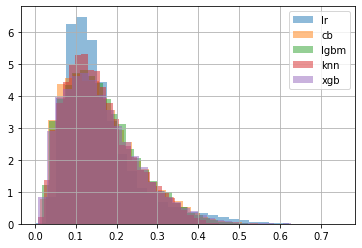

In [124]:
new_train_df['lr'].hist(alpha=0.5, bins=30, density='uniform', label='lr')
new_train_df['cb'].hist(alpha=0.5, bins=30, density='uniform', label='cb')
new_train_df['lgbm'].hist(alpha=0.5, bins=30, density='uniform', label='lgbm')
new_train_df['knn'].hist(alpha=0.5, bins=30, density='uniform', label='knn')
new_train_df['xgb'].hist(alpha=0.5, bins=30, density='uniform', label='xgb')
plt.legend()
plt.show()


In [125]:
skf = StratifiedKFold(n_splits=5, random_state=18, shuffle=True)
cb_scores, cb_result, cb_oof_result = do_cv(
    catboost_train,
    catboost_test,
    catboost_train['def'],
    catboost_columns,
    catboost_cat_features,
    catboost_params,
    skf,
    'catboost'
)

lr_scores, lr_result, lr_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    lr_cols,
    [],
    lr_params,
    skf,
    'logreg',
)

lgbm_scores, lgbm_result, lgbm_oof_result = do_cv(
    lgbm_train,
    lgbm_test,
    lgbm_train['def'],
    lgbm_columns,
    lgbm_cat_features,
    lgbm_params,
    skf,
    'lgbm'
)

knn_scores, knn_result, knn_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    knn_columns,
    [],
    knn_params,
    skf,
    'knn'
)

xgb_scores, xgb_result, xgb_oof_result = do_cv(
    lgbm_train,
    lgbm_test,
    lgbm_train['def'],
    xgb_columns,
    [],
    xgb_params,
    skf,
    'xgboost'
)

0:	test: 0.5522372	best: 0.5522372 (0)	total: 9.42ms	remaining: 18.8s
50:	test: 0.6733680	best: 0.6733680 (50)	total: 601ms	remaining: 23s
100:	test: 0.6775507	best: 0.6775507 (100)	total: 1.18s	remaining: 22.3s
150:	test: 0.6788783	best: 0.6788945 (147)	total: 1.78s	remaining: 21.8s
200:	test: 0.6797660	best: 0.6797944 (199)	total: 2.42s	remaining: 21.7s
250:	test: 0.6802881	best: 0.6803017 (242)	total: 3.28s	remaining: 22.8s
300:	test: 0.6807471	best: 0.6807963 (296)	total: 3.9s	remaining: 22s
350:	test: 0.6809750	best: 0.6809750 (350)	total: 4.47s	remaining: 21s
400:	test: 0.6811271	best: 0.6811271 (400)	total: 5.04s	remaining: 20.1s
450:	test: 0.6812085	best: 0.6812324 (443)	total: 5.6s	remaining: 19.2s
500:	test: 0.6811790	best: 0.6812324 (443)	total: 6.19s	remaining: 18.5s
550:	test: 0.6811135	best: 0.6812324 (443)	total: 6.81s	remaining: 17.9s
600:	test: 0.6810332	best: 0.6812324 (443)	total: 7.39s	remaining: 17.2s
650:	test: 0.6809930	best: 0.6812324 (443)	total: 7.99s	remainin

1700:	test: 0.7019821	best: 0.7021364 (1474)	total: 21.5s	remaining: 3.78s
1750:	test: 0.7019765	best: 0.7021364 (1474)	total: 22.1s	remaining: 3.14s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7021364439
bestIteration = 1474

Shrink model to first 1475 iterations.


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.674937	valid_0's binary_logloss: 0.416012
[200]	valid_0's auc: 0.677544	valid_0's binary_logloss: 0.413914
[300]	valid_0's auc: 0.678249	valid_0's binary_logloss: 0.413452
[400]	valid_0's auc: 0.67875	valid_0's binary_logloss: 0.413299
[500]	valid_0's auc: 0.679045	valid_0's binary_logloss: 0.413263
Early stopping, best iteration is:
[472]	valid_0's auc: 0.67907	valid_0's binary_logloss: 0.413242


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.674345	valid_0's binary_logloss: 0.416479
[200]	valid_0's auc: 0.678662	valid_0's binary_logloss: 0.414022
[300]	valid_0's auc: 0.680979	valid_0's binary_logloss: 0.413174
[400]	valid_0's auc: 0.681832	valid_0's binary_logloss: 0.412825
[500]	valid_0's auc: 0.682222	valid_0's binary_logloss: 0.412732
Early stopping, best iteration is:
[527]	valid_0's auc: 0.682301	valid_0's binary_logloss: 0.412708


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.678822	valid_0's binary_logloss: 0.415126
[200]	valid_0's auc: 0.684449	valid_0's binary_logloss: 0.412182
[300]	valid_0's auc: 0.686147	valid_0's binary_logloss: 0.411198
[400]	valid_0's auc: 0.686715	valid_0's binary_logloss: 0.410822
[500]	valid_0's auc: 0.686931	valid_0's binary_logloss: 0.410705
Early stopping, best iteration is:
[460]	valid_0's auc: 0.686985	valid_0's binary_logloss: 0.410717


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.673714	valid_0's binary_logloss: 0.416281
[200]	valid_0's auc: 0.677149	valid_0's binary_logloss: 0.41388
[300]	valid_0's auc: 0.67935	valid_0's binary_logloss: 0.412956
[400]	valid_0's auc: 0.680272	valid_0's binary_logloss: 0.41266
[500]	valid_0's auc: 0.680404	valid_0's binary_logloss: 0.412624
Early stopping, best iteration is:
[456]	valid_0's auc: 0.680494	valid_0's binary_logloss: 0.412594


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.68897	valid_0's binary_logloss: 0.413106
[200]	valid_0's auc: 0.695358	valid_0's binary_logloss: 0.409559
[300]	valid_0's auc: 0.698827	valid_0's binary_logloss: 0.408071
[400]	valid_0's auc: 0.700548	valid_0's binary_logloss: 0.407333
[500]	valid_0's auc: 0.700928	valid_0's binary_logloss: 0.407133
[600]	valid_0's auc: 0.701464	valid_0's binary_logloss: 0.406923
Early stopping, best iteration is:
[608]	valid_0's auc: 0.70148	valid_0's binary_logloss: 0.406912
[0]	validation_0-auc:0.60924
Will train until validation_0-auc hasn't improved in 150 rounds.
[100]	validation_0-auc:0.67713
[200]	validation_0-auc:0.67899
[300]	validation_0-auc:0.67919
[400]	validation_0-auc:0.67946
[500]	validation_0-auc:0.68005
[600]	validation_0-auc:0.68031
[700]	validation_0-auc:0.68030
Stopping. Best iteration:
[642]	va

In [126]:
new_train_df = pd.DataFrame({
    'lr':lr_oof_result,
    'cb':cb_oof_result,
    'lgbm': lgbm_oof_result,
    'knn': knn_oof_result,
    'xgb': xgb_oof_result,
})
new_test_df = pd.DataFrame({
    'lr':lr_result,
    'cb':cb_result,
    'lgbm': lgbm_result,
    'knn': knn_result,
    'xgb': xgb_result,
})

In [127]:
lr = LogisticRegression(C=best_c, solver='liblinear')
scores = cross_val_score(lr, new_train_df, logreg_train['def'], cv=5, scoring='roc_auc')

In [128]:
np.mean(scores), np.std(scores)

(0.6880779690462692, 0.00803963076803046)

In [129]:
np.mean(scores), np.std(scores)

(0.6880779690462692, 0.00803963076803046)

In [130]:
lr_f_scores, lr_f_result, lr_f_oof_result = do_cv(
    new_train_df,
    new_test_df,
    logreg_train['def'],
    new_train_df.columns,
    [],
    {},
    skf,
    'logreg',
)

In [131]:
logreg_test['prob'] = lr_f_result

In [132]:
logreg_test[['id', 'prob']].to_csv('blend_v1_eited_submission.csv', index=False)